In [1]:
import relative_imports

In [2]:
import sys
sys.path.insert(1, "/HOME1/users/students/shvl/projects/spatiotemporal")

%matplotlib ipympl

from spatiotemporal.SEN12MSCRTS import DatasetManager, ImageUtils
from torch_datasets.minimal_dataset import S2Dataset
from tqdm.notebook import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from os.path import join
from torch.utils.data import DataLoader
import xarray as xr
xr.set_options(display_expand_data=False)

In [3]:
root_dir='/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS'
cloud_maps_dir="/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS_cloud_maps"
cloud_histograms_csv = join(cloud_maps_dir, "cloud_histograms.csv")

In [4]:
dataset_manager = DatasetManager(
    root_dir=root_dir,
    cloud_maps_dir=cloud_maps_dir,
    cloud_probability_threshold=0.95
)

In [5]:
dataset_manager_path = join(dataset_manager.project_directory, "config", "dataset_manager.csv")

# dataset_manager.load_dataset()
# dataset_manager.save_to_file(dataset_manager_path)
dataset_manager.load_from_file(dataset_manager_path)

# Example

In [ ]:
index = dataset_manager.data.index[14444]
index

In [ ]:
cloud_map = dataset_manager.utils.get_cloud_map(index=index)
cloud_map = cloud_map.squeeze(axis=0)
cloud_map.shape

In [ ]:
categorical_cloud_map = dataset_manager.utils.get_categorical_cloud_map(index=index)
categorical_cloud_map = categorical_cloud_map.squeeze(axis=0)
categorical_cloud_map.shape, categorical_cloud_map.dtype

In [ ]:
cloud_masks = ~np.cumsum(categorical_cloud_map, axis=-1).astype(bool)
cloud_masks.shape, cloud_masks.dtype

In [ ]:
bins = dataset_manager.cloud_probability_bins
left_bin_edges = bins[:-1]
right_bin_edges = bins[1:]

In [ ]:
with plt.ioff():
    fig_1, axs_1 = plt.subplots(figsize=(14, 5), ncols=3, subplot_kw={"aspect": "auto"})

In [ ]:
axs_1[0].imshow(cloud_map, vmin=0.0, vmax=1.0)
axs_1[0].set_title("Cloud probability map")

categorical_cloud_map_image = axs_1[1].imshow(categorical_cloud_map[..., 10], vmin=0.0, vmax=1.0, cmap="PuOr_r")
axs_1[1].set_title("Categorical cloud probability map")

cloud_mask_image = axs_1[2].imshow(cloud_masks[..., 10], vmin=0.0, vmax=1.0)
axs_1[2].set_title("Cloud mask (thresholded)")

slider_1 = widgets.SelectionSlider(
    options=[(f"{edge:.2f}", i) for i, edge in enumerate(right_bin_edges)],
    value=10,
    description='Threshold cloud probability: ',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="auto")
)

def update_im_1(index):
    
    # update cloud mask
    categorical_cloud_map_image.set_data(categorical_cloud_map[..., index])
    cloud_mask_image.set_data(cloud_masks[..., index])
    fig_1.canvas.draw_idle()

slider_1_widget = interactive(update_im_1, index=slider_1)

In [ ]:
display(fig_1.canvas, slider_1_widget)
# display(fig_1)

In [ ]:
# plt.close(fig_1)

# Process single batch

In [ ]:
MAX_VALUE = 10000

In [ ]:
def apply_mask(image, mask, channel_dim=1):
    image_view = np.moveaxis(image, channel_dim, -1)
    mask_view = mask.squeeze(axis=channel_dim)
    result = image_view[mask_view]
    result = np.moveaxis(result, 0, -1)
    return result

In [ ]:
dataset = S2Dataset(dataset_manager=dataset_manager, mode="train")

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    # num_workers=32,
    collate_fn=dataset.collate_fn,
    # prefetch_factor=2
)

In [ ]:
iterator = iter(data_loader)
batch = next(iterator)

In [ ]:
image = batch["S2_image"]
image = np.clip(image, a_min=None, a_max=MAX_VALUE-1)
categorical_cloud_map = batch["categorical_cloud_map"]

image.shape, image.dtype, categorical_cloud_map.shape, categorical_cloud_map.dtype

In [ ]:
categorical_cloud_map = np.moveaxis(categorical_cloud_map, -1, 0)
categorical_cloud_map.shape

In [ ]:
batch_histogram = []

for cloud_probability_mask in categorical_cloud_map:
    result = np.apply_along_axis(
        func1d=np.bincount,
        axis=1,
        arr=apply_mask(image=image, mask=cloud_probability_mask),
        minlength=MAX_VALUE
    )
    batch_histogram.append(result)

In [ ]:
batch_histogram = np.stack(batch_histogram)
batch_histogram.shape

In [ ]:
batch_histogram = np.stack([
    np.apply_along_axis(
        func1d=np.bincount,
        axis=1,
        arr=apply_mask(image=image, mask=cloud_probability_mask),
        minlength=MAX_VALUE
    )
    for cloud_probability_mask 
    in categorical_cloud_map
])

In [ ]:
batch_histogram.shape

# Process whole dataset

In [ ]:
MAX_VALUE = 10000

# check that no overflow pf int64 happens when calculating histograms
assert 256 * 256 * len(dataset) < np.iinfo(np.int64).max

In [ ]:
def apply_mask(image, mask, channel_dim=1):
    image_view = np.moveaxis(image, channel_dim, -1)
    mask_view = mask.squeeze(axis=channel_dim)
    result = image_view[mask_view]
    result = np.moveaxis(result, 0, -1)
    return result

In [ ]:
dataset = S2Dataset(dataset_manager=dataset_manager, mode="train")

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    num_workers=32,
    collate_fn=dataset.collate_fn,
    prefetch_factor=2
)

In [ ]:
dataset_histogram = np.zeros(
    (
        dataset_manager.cloud_probability_bins.size - 1,
        13,
        MAX_VALUE
    ),
    dtype=np.int64
)
dataset_histogram.shape, dataset_histogram.dtype

In [ ]:
try:
    for batch in tqdm(data_loader, desc="Calculating dataset histogram", unit=" batch"):

        image = batch["S2_image"]
        image = np.clip(image, a_min=None, a_max=MAX_VALUE-1)

        categorical_cloud_map = batch["categorical_cloud_map"]
        categorical_cloud_map = np.moveaxis(categorical_cloud_map, -1, 0)

        batch_histogram = np.stack([
            np.apply_along_axis(
                func1d=np.bincount,
                axis=1,
                arr=apply_mask(image=image, mask=cloud_probability_mask),
                minlength=MAX_VALUE
            )
            for cloud_probability_mask 
            in categorical_cloud_map
        ])

        dataset_histogram += batch_histogram
        
except KeyboardInterrupt:
    pass

In [ ]:
S2_band_numbers = ["1", "2", "3", "4", "5", "6", "7", "8", "8A", "9", "10", "11", "12"]
S2_band_names = [
    "Coastal aerosol",
    "Blue",
    "Green",
    "Red",
    "Vegetation red edge 704nm",
    "Vegetation red edge 740nm",
    "Vegetation red edge 783nm",
    "NIR",
    "Narrow NIR",
    "Water vapour",
    "SWIR Cirrus",
    "SWIR 1600nm",
    "SWIR 2200nm"
]
S2_band_resolutions = ["60m", "10m", "10m", "10m", "20m", "20m", "20m", "10m", "20m", "60m", "60m", "20m", "20m"]

len(S2_band_numbers), len(S2_band_names), len(S2_band_resolutions)

In [ ]:
dataset_histogram_xr = xr.DataArray(
    data=dataset_histogram,
    dims=["Bin", "Band", "Reflectance"],
    coords={
        "Cloud_probability_bin": ("Bin", range(dataset_manager.cloud_probability_bins.size - 1)),
        "Left_bin_edge": ("Bin", dataset_manager.cloud_probability_bins[:-1]),
        "Right_bin_edge": ("Bin", dataset_manager.cloud_probability_bins[1:]),
        "Band": ("Band", S2_band_numbers),
        "Band_name": ("Band", S2_band_names),
        "Band_resolution": ("Band", S2_band_resolutions),
        "Reflectance": ("Reflectance", np.arange(0, 10000))
    },
    name="Sentinel-2 histogram",
    attrs={"subset": "train"}
).to_dataset()

dataset_histogram_xr["Sentinel-2 histogram"]

In [ ]:
dataset_histogram_xr["Sentinel-2 histogram"].dtype

In [ ]:
# XArray will convert the data to int32. Check if there will be no overflow
assert dataset_histogram_xr["Sentinel-2 histogram"].values.max() < np.iinfo(np.int32).max

In [ ]:
dataset_histogram_xr.to_netcdf(
    path=join(dataset_manager.project_directory, "stats", "S2_train_dataset_histogram.nc")
)

# Load histograms from disc and plot results

In [6]:
saved_histograms = xr.load_dataset(
    join(dataset_manager.project_directory, "stats", "S2_train_dataset_histogram.nc")
)
saved_histograms = saved_histograms["Sentinel-2 histogram"]

saved_histograms

<xarray.DataArray 'Sentinel-2 histogram' (Bin: 20, Band: 13, Reflectance: 10000)>
113091864 18292 2787 678 244 3 63 0 0 ... 321 221 258 273 311 263 283 313 216530
Coordinates:
  * Reflectance            (Reflectance) int32 0 1 2 3 4 ... 9996 9997 9998 9999
    Cloud_probability_bin  (Bin) int32 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    Left_bin_edge          (Bin) float64 0.0 0.05 0.1 0.15 ... 0.8 0.85 0.9 0.95
    Right_bin_edge         (Bin) float64 0.05 0.1 0.15 0.2 ... 0.85 0.9 0.95 1.0
    Band_name              (Band) object 'Coastal aerosol' ... 'SWIR 2200nm'
    Band_resolution        (Band) object '60m' '10m' '10m' ... '60m' '20m' '20m'
  * Band                   (Band) object '1' '2' '3' '4' ... '9' '10' '11' '12'
Dimensions without coordinates: Bin
Attributes:
    subset:   train

In [7]:
saved_histograms.dtype

dtype('int32')

In [8]:
# remove zeros, so that we can show log values
saved_histograms.values[saved_histograms.values == 0] = 1

(saved_histograms == 0).values.any()

False

In [9]:
# calculate 99 percentile value to remove outliers
histogram_99_percentile = np.percentile(saved_histograms.values, 99, axis=(0, 2))
histogram_99_percentile.shape

(13,)

In [10]:
cmaps = {
    "10m": "inferno",
    "20m": "viridis",
    "60m": "cividis"
}

In [11]:
with plt.ioff():
    fig_2, ax_2 = plt.subplots(nrows=1, ncols=2, figsize=(11, 6), gridspec_kw={'width_ratios': [20, 1]})

In [12]:
default_band = 3

# fig_2.tight_layout()
fig_2.suptitle("Reflectance-cloud histogram", fontsize=18)

band_histogram_image = ax_2[0].imshow(
    saved_histograms.isel(Band=default_band),
    aspect="auto",
    extent=(0, 10000, 1, 0),
    cmap=cmaps[saved_histograms.isel(Band=default_band).Band_resolution.item()],
    norm=mpl.colors.LogNorm(vmin=1, vmax=histogram_99_percentile[default_band])
)

ax_2[0].set_title(f"Band {saved_histograms.isel(Band=default_band).Band.item()}"
                  f" - {saved_histograms.isel(Band=default_band).Band_name.item()}")
ax_2[0].set_xlabel("Reflectance value")
ax_2[0].set_ylabel("Cloud probability [%]")

cbar_2 = fig_2.colorbar(band_histogram_image, cax=ax_2[1], ax=ax_2[0], label="Number of pixels")

slider_2 = widgets.SelectionSlider(
    options=[(name.item(), i) for i, name in enumerate(saved_histograms.Band_name)],
    value=default_band,
    description='Band: ',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)

In [13]:
def update_im_2(band):
    
    # update cloud mask
    band_histogram_image.set_data(saved_histograms.isel(Band=band))
    band_histogram_image.set_cmap(cmaps[saved_histograms.isel(Band=band).Band_resolution.item()])
    band_histogram_image.set(norm=mpl.colors.LogNorm(vmin=1, vmax=histogram_99_percentile[band]))
    ax_2[0].set_title(f"Band {saved_histograms.isel(Band=band).Band.item()}"
                      f" - {saved_histograms.isel(Band=band).Band_name.item()}")
    
    fig_2.canvas.draw_idle()

slider_2_widget = interactive(update_im_2, band=slider_2)

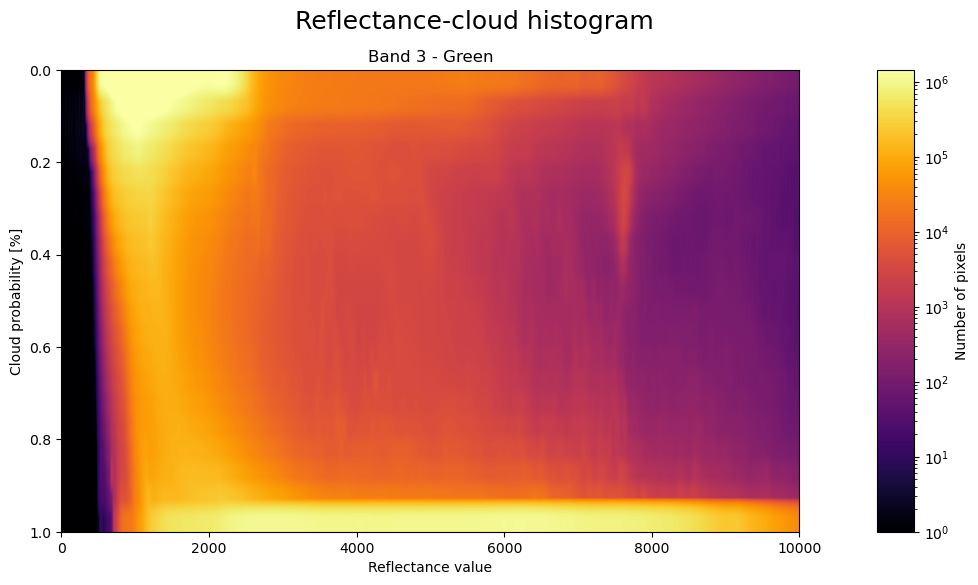

In [15]:
# display(fig_2.canvas, slider_2_widget)
display(fig_2)

In [16]:
plt.close(fig_2)